In [8]:
import sys

import np

sys.path.insert(0, '/home/dom/AIR/air25')

import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.config import CLAIMS_PATH
from src.a2.pipeline import run_pipeline
from src.a2.eval import evaluate_voting_results

In [9]:
# config

RANDOM_STATE = 21
TEST_SIZE = 0.2

K_RETRIEVE = 100
K_VOTE = 10
USE_WEIGHTED = False

In [10]:
# create validation batch
all_claims = pd.read_csv(CLAIMS_PATH)

train_set, val_set = train_test_split(
    all_claims,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=all_claims['claim_label']
)

print(f"Validation batch size: {len(val_set)}")

Validation batch size: 276


In [11]:
# run

#results = run_pipeline(claims_df=val_set, k_retrieve=K_RETRIEVE, k_vote=K_VOTE,use_weighted=USE_WEIGHTED)

#joblib.dump(results, 'pipeline_results_2_ret.joblib')
results = joblib.load('pipeline_results_2_ret.joblib')

['pipeline_results_2_ret.joblib']

In [12]:
acc, f1_macro, f1_weighted, report, y_pred, y_true = evaluate_voting_results(results, CLAIMS_PATH)

print(f"Accuracy: {acc:.4f}")
print(f"F1_Macro: {f1_macro:.4f}")
print(f"F1_Weighted: {f1_weighted:.4f}")
print(f"Classification report: {report}")

Accuracy: 0.6486
F1_Macro: 0.5935
F1_Weighted: 0.6340
Classification report:                  precision    recall  f1-score   support

NOT_ENOUGH_INFO       0.57      0.87      0.69        94
        REFUTES       0.68      0.29      0.41        51
       SUPPORTS       0.75      0.63      0.68       131

       accuracy                           0.65       276
      macro avg       0.67      0.60      0.59       276
   weighted avg       0.68      0.65      0.63       276



In [13]:
# cm

VALID_LABELS = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO']
cm = confusion_matrix(y_true, y_pred, labels=VALID_LABELS)
print("Confusion Matrix:")
print(f"Labels: {VALID_LABELS}")
print(cm)

Confusion Matrix:
Labels: ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO']
[[82  6 43]
 [16 15 20]
 [11  1 82]]


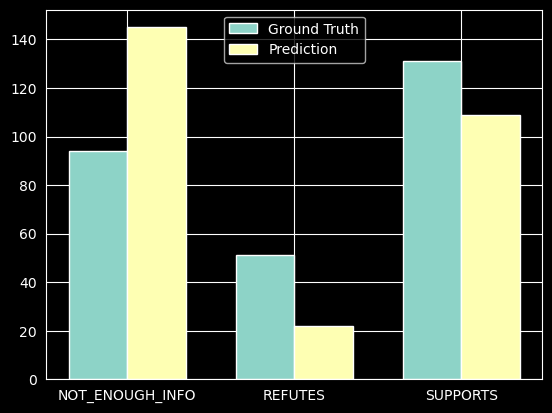

In [24]:
from matplotlib import pyplot as plt
from collections import Counter

labels = ['NOT_ENOUGH_INFO', 'REFUTES', 'SUPPORTS']
gt_vals = [gt_counts.get(k, 0) for k in labels]
pred_vals = [pred_counts.get(k, 0) for k in labels]

x = np.arange(len(labels))
w = 0.35

plt.bar(x - w/2, gt_vals, w, label='Ground Truth')
plt.bar(x + w/2, pred_vals, w, label='Prediction')

plt.xticks(x, labels)
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import precision_recall_fscore_support

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=VALID_LABELS, zero_division=0
)

per_class_df = pd.DataFrame({
    'Class': VALID_LABELS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print("Per-Class Metrics:")
print(per_class_df.to_string(index=False))

Per-Class Metrics:
          Class  Precision   Recall  F1-Score  Support
       SUPPORTS   0.752294 0.625954  0.683333      131
        REFUTES   0.681818 0.294118  0.410959       51
NOT_ENOUGH_INFO   0.565517 0.872340  0.686192       94


In [16]:
import numpy as np

# Save for comparison notebook
results_dict = {
    'results': results,
    'y_true': y_true,
    'y_pred': y_pred,
    'accuracy': acc,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'confusion_matrix': cm,
    'per_class': per_class_df.to_dict(),
}

np.save('eval_results_a2.npy', results_dict, allow_pickle=True)